<a href="https://colab.research.google.com/github/mukundn/notes/blob/main/notebooks/sgd_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline
import matplotlib.pyplot as plt

from numpy import ma
from matplotlib import colors, ticker, cm

from sklearn import datasets

Gradient Descent algorithms can act in weird ways sometimes, and the purpose of this notebook is to visualize some of this behaviour, and connect what is going on when you look at the loss curve with what is going on the parameter space.

Most of the time, then models will have thousands (or millions) of parameters, much of the behaviour can be be understood by just looking at a simplified model with 2 parameters. The error surface can be pretty complicated, but locally it looks like a quadratic bowl.

The root of all problems in gradient descent is that different dimensions have different natural scales (and so we should be taking steps of different sizes in different dimensions), but basic algorithms treat all dimension the same. This is perhaps a little bit of an overgeneralization, but only a little.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'linewidth'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'


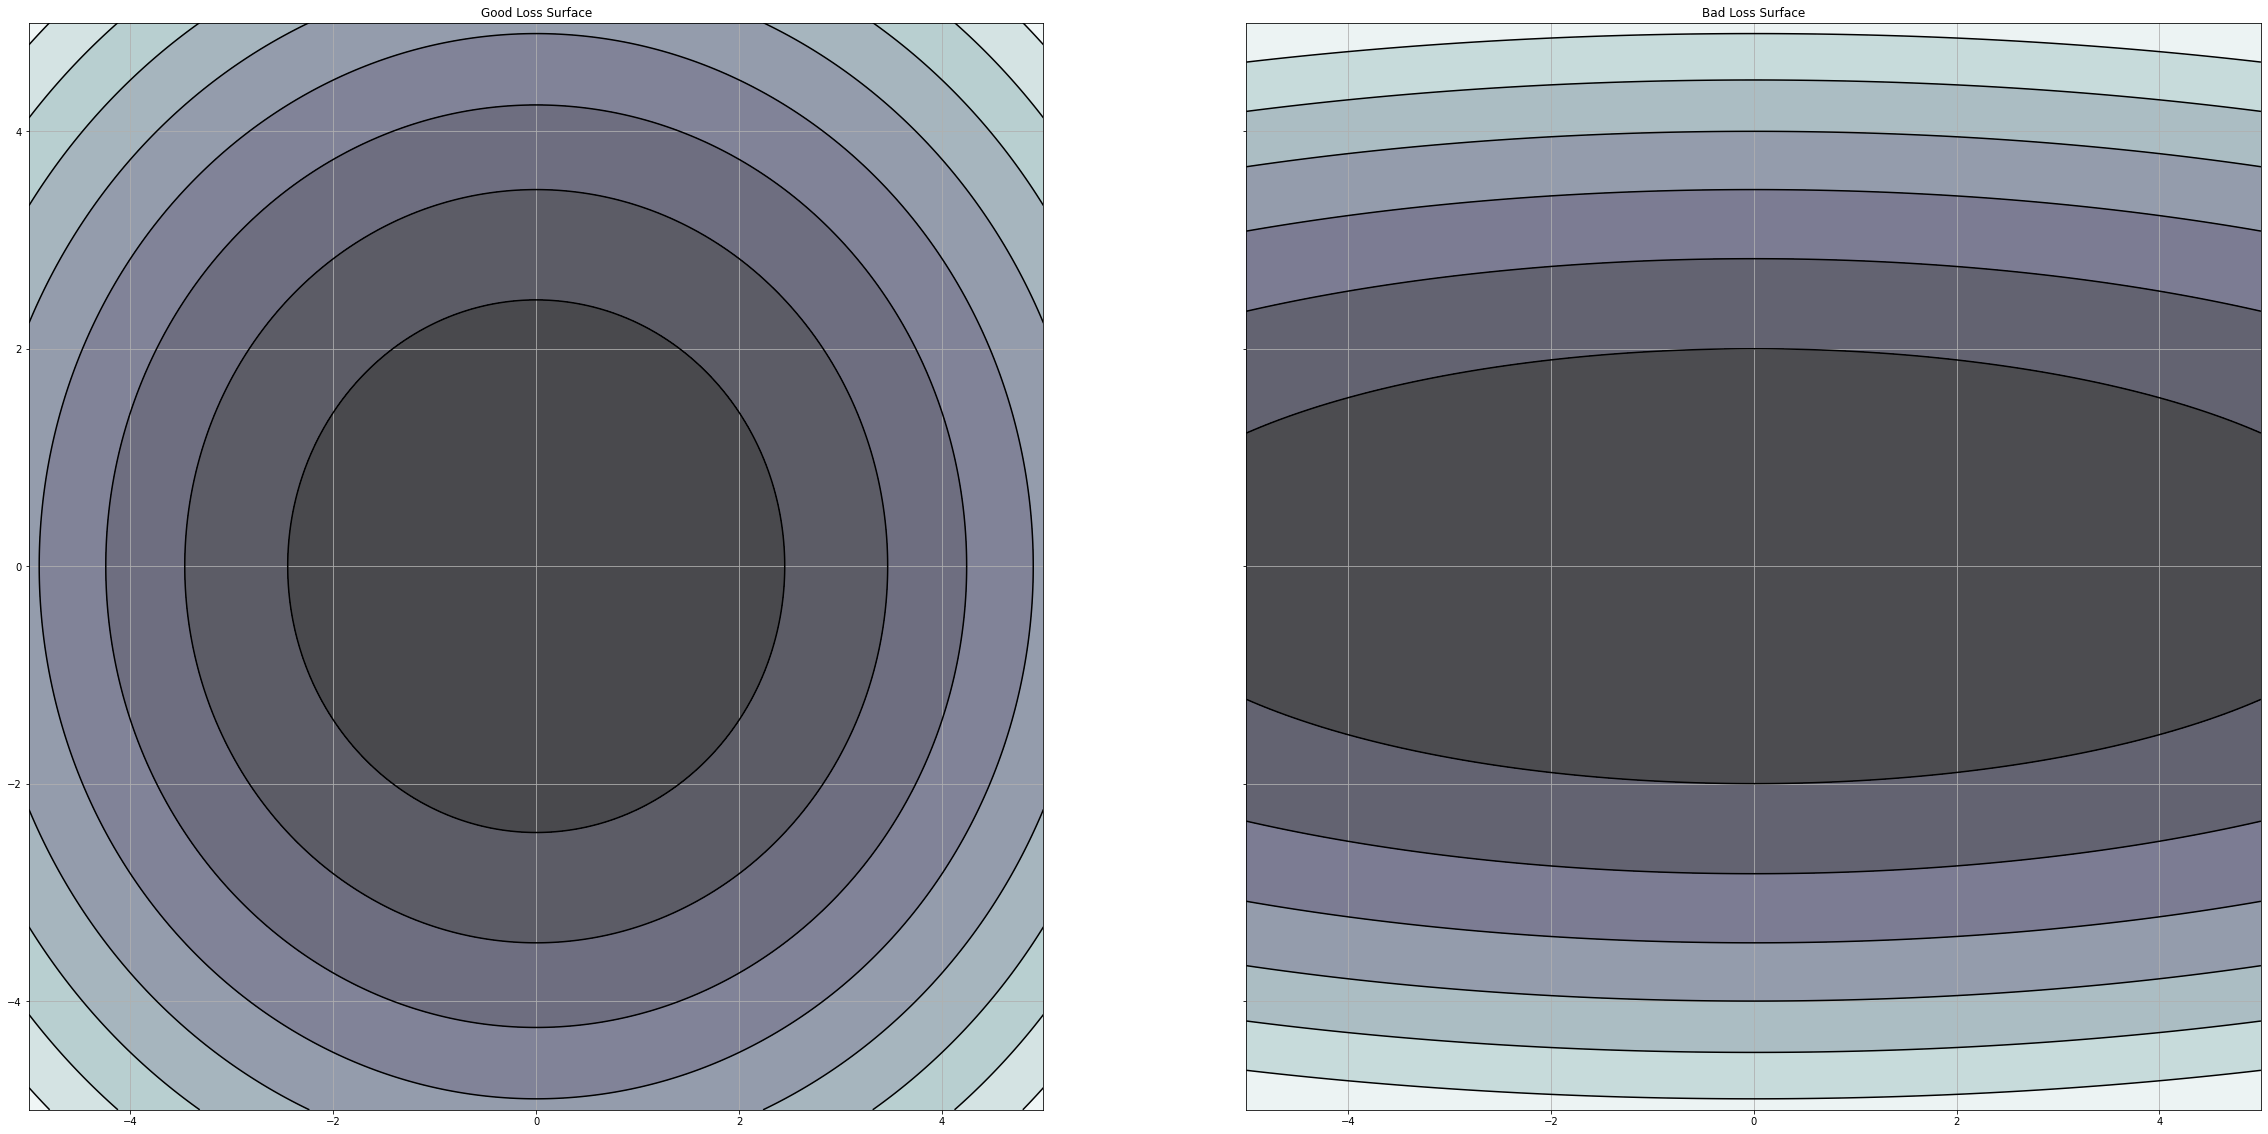

In [ ]:
def good_case(x, y):
    """Nicely behaved surface - well conditioned hessian"""
    return x ** 2 + y ** 2

def bad_case(x, y):
    """Badly behaved surface - badly conditioned hessian"""
    return 0.05 * (x ** 2) + 0.5 * (y ** 2)

num_points = 512
x = np.linspace(-5, 5, num_points)
y = np.linspace(-5, 5, num_points)
xx, yy = np.meshgrid(x, y)
bad_eval = bad_case(xx, yy)
good_eval = good_case(xx, yy)

# fig, ax = plt.subplots()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(40, 20))
ax1.contourf(xx, yy, good_eval, 8, alpha=.75, cmap=plt.cm.bone)
C = ax1.contour(xx, yy, good_eval, 8, colors='black', linewidth=.5)
ax1.grid(True)
ax1.set_title('Good Loss Surface')

ax2.contourf(xx, yy, bad_eval, 8, alpha=.75, cmap=plt.cm.bone)
C = ax2.contour(xx, yy, bad_eval, 8, colors='black', linewidth=.5)
ax2.grid(True)
ax2.set_title('Bad Loss Surface')


plt.show()

While the difference in scale of features is something that can be be accounted for relatively easily in dense feature vectors, it is trickier in sparse vectors. Particularly for the embeddings use case, a lot of the IDs (and hence the parameter updates) occur very infrequently. So two things to keep in mind while we go through these examples are
- How does the algorithm handle sparse updates?
- How does the algorithm handle ill-conditioned hessians?

To generate the visualizations, we will use the iris and boston datasets (these are old classics - almost trivial data sets, but still complex enough to simulate the behaviour we are interested in).

Also, we will be using gradients computed from the entire data set - this is because we want to simplify by removing the stochastic noise, and also because the dataset is only about 150 examples, and so the entire dataset size smaller than the typical minibatch size.

In [ ]:
def feature_name_to_idx(dataset, feature_name):
  for idx, full_name in enumerate(dataset.feature_names):
    if feature_name in full_name:
      print('Using feature: {f}'.format(f=full_name))
      return idx
  raise Exception('Could not find feature with name: ' + feature_name)

def get_logistic_regression_dataset(feature_names=['sepal length', 'sepal width'], target=1):
  dataset = datasets.load_iris()
  labels = (dataset.target == target).astype(dtype=np.float32)
  feature_idx = [feature_name_to_idx(dataset, f) for f in feature_names]
  feature_data = dataset.data[:, feature_idx]
  return (labels, feature_data.astype(np.float32))

In [ ]:
labels, features = get_logistic_regression_dataset()

Using feature: sepal length (cm)
Using feature: sepal width (cm)


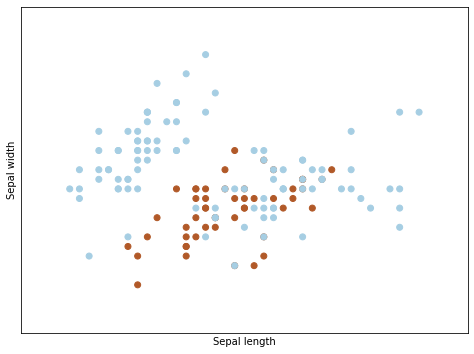

In [ ]:
x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Update Equations for various algorithms
 
 $$
 \begin{align*}
 \mathrm{Gradient} & & g^t &\leftarrow & \frac{\partial L}{\partial w} \\ \hline
 \mathrm{GD} & & w^{t+1} & \leftarrow & w^{t} - \eta g^t \\ \hline
 \mathrm{Momentum} & & v^{t+1} & \leftarrow & \alpha \cdot v^{t} - \eta \cdot g^t \\
                   & & w^{t+1} & \leftarrow & w^{t} + v^{t+1} \\ \hline
 \mathrm{AdaGrad}  & & G^{t+1} & \leftarrow & G^{t} + \left(g^t\right)^2 \\
                   & & w^{t+1} & \leftarrow & w^t - \frac{\eta}{\sqrt{G^{t}}} \cdot g^{t} \\ \hline
 \mathrm{Adam}     & & m^{t+1} & \leftarrow & \beta_1 \cdot m^{t} + (1 - \beta_1) \cdot g^{t} \\
                   & & \nu^{t+1} & \leftarrow & \beta_2 \cdot \nu^{t} + (1 - \beta_2) \cdot \left(g^{t}\right)^2 \\
                   & & w^{t+1} & \leftarrow & w^{t} - \frac{\eta}{\sqrt{\hat{\nu^{t}} + \epsilon}} \cdot \hat{m^{t}} \\ \hline
 \end{align*}
 $$

The table above shows the main algorithms that we will be comparing and the update equations they use. We want to visualize what these different learning algorithms do (as in, visualize the path of updates to the parameters). We want to do this for different algorithms (standard SGD, Momentum, Adagrad, RMSProp, ADAM, etc.), as well as different starting points.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
train_dataset_batched = train_dataset.batch(batch_size = 1024)
train_dataset_batched = train_dataset_batched.repeat(None)
f, l = next(iter(train_dataset_batched))

In [ ]:
from tensorflow.keras.callbacks import History, Callback


def mk_model():
    inp = tf.keras.layers.Input(shape=f.shape[1], dtype=tf.float32, name='features')
    out = tf.keras.layers.Dense(1, activation='sigmoid', use_bias=False)(inp)
    model = tf.keras.Model(inputs=inp, outputs=out, name='TwoParameterModel')
    return model


class WeightHistory(Callback):
    def __init__(self):
        self.w_history = []

    def on_epoch_begin(self, epoch, logs=None):
        w = self.model.weights[0].numpy()
        self.w_history.append(w.reshape(2))


def run(optimizer, epochs, init_params=None):
    model = mk_model()
    lhistory = History()
    whistory = WeightHistory()

    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))
    if init_params is not None:
        p = np.array(init_params, dtype=np.float32).reshape(2, 1)
        model.set_weights([p])
    model.fit(train_dataset_batched, 
              steps_per_epoch=1, epochs=epochs, callbacks=[lhistory, whistory],
              verbose=0)
    return (model, lhistory.history['loss'], np.array(whistory.w_history))

In [ ]:
class Grid(object):
    def __init__(self, fvecs, labels, num_points=512):
        self.fvecs = fvecs
        self.labels = labels
        # define grid.
        self.num_points = 512
        self.x_range = np.linspace(-5, 5, num_points)
        self.y_range = np.linspace(-10, 10, num_points)
        # Precompute losses on the grid.
        self.loss_grid = self.losses()
        self.x_grid, self.y_grid = np.meshgrid(self.x_range, self.y_range)
        
    def losses(self):
        num_recs = self.labels.size
        xr = self.x_range.reshape(1, self.num_points)
        yr = self.y_range.reshape(self.num_points, 1)
        losses = []
        for rec_num in range(num_recs):
            fvec, l = self.fvecs[rec_num], self.labels[rec_num]
            ss = np.maximum(-12, np.minimum(12, xr * fvec[0] + yr * fvec[1]))
            probs = np.exp(ss) / (np.exp(ss) + 1.0)
            loss = -np.log(probs) * l - np.log(1 - probs) * (1 - l)
            losses.append(loss)
        return np.mean(losses, axis=0, dtype=np.float64)
    
    def plot_loss_surface(self, path=None):
        x, y, l = self.x_grid, self.y_grid, self.loss_grid
        plt.axes([-5, -5, 5, 5])
        plt.contourf(x, y, l, 8, alpha=.75, cmap=plt.cm.bone)
        C = plt.contour(x, y, l, 8, colors='black', linewidth=.5)
        plt.clabel(C, inline=1, fontsize=10)
        if path is not None:
            path_x = path[:, 0]
            path_y = path[:, 1]
            path_len = len(path)
            colors = iter(cm.rainbow(np.linspace(0, 1, path_len)))
            for i in range(250):
                plt.scatter(x=path_x[i], y=path_y[i], color=next(colors))
            plt.plot(path_x, path_y, alpha=0.3)
        plt.grid(True)
        plt.show()
        
    def plot_loss_curve(self, losses):
        plt.plot(losses)
        plt.show()
        

g = Grid(f.numpy(), l.numpy())

In [ ]:
def viz(optimizer, num_epochs=250, init_params=None):
    model, losses, param_path = run(optimizer, num_epochs, init_params)
    g.plot_loss_curve(losses)
    g.plot_loss_surface(param_path)

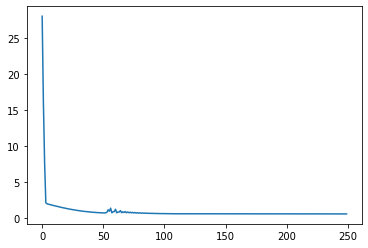

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'


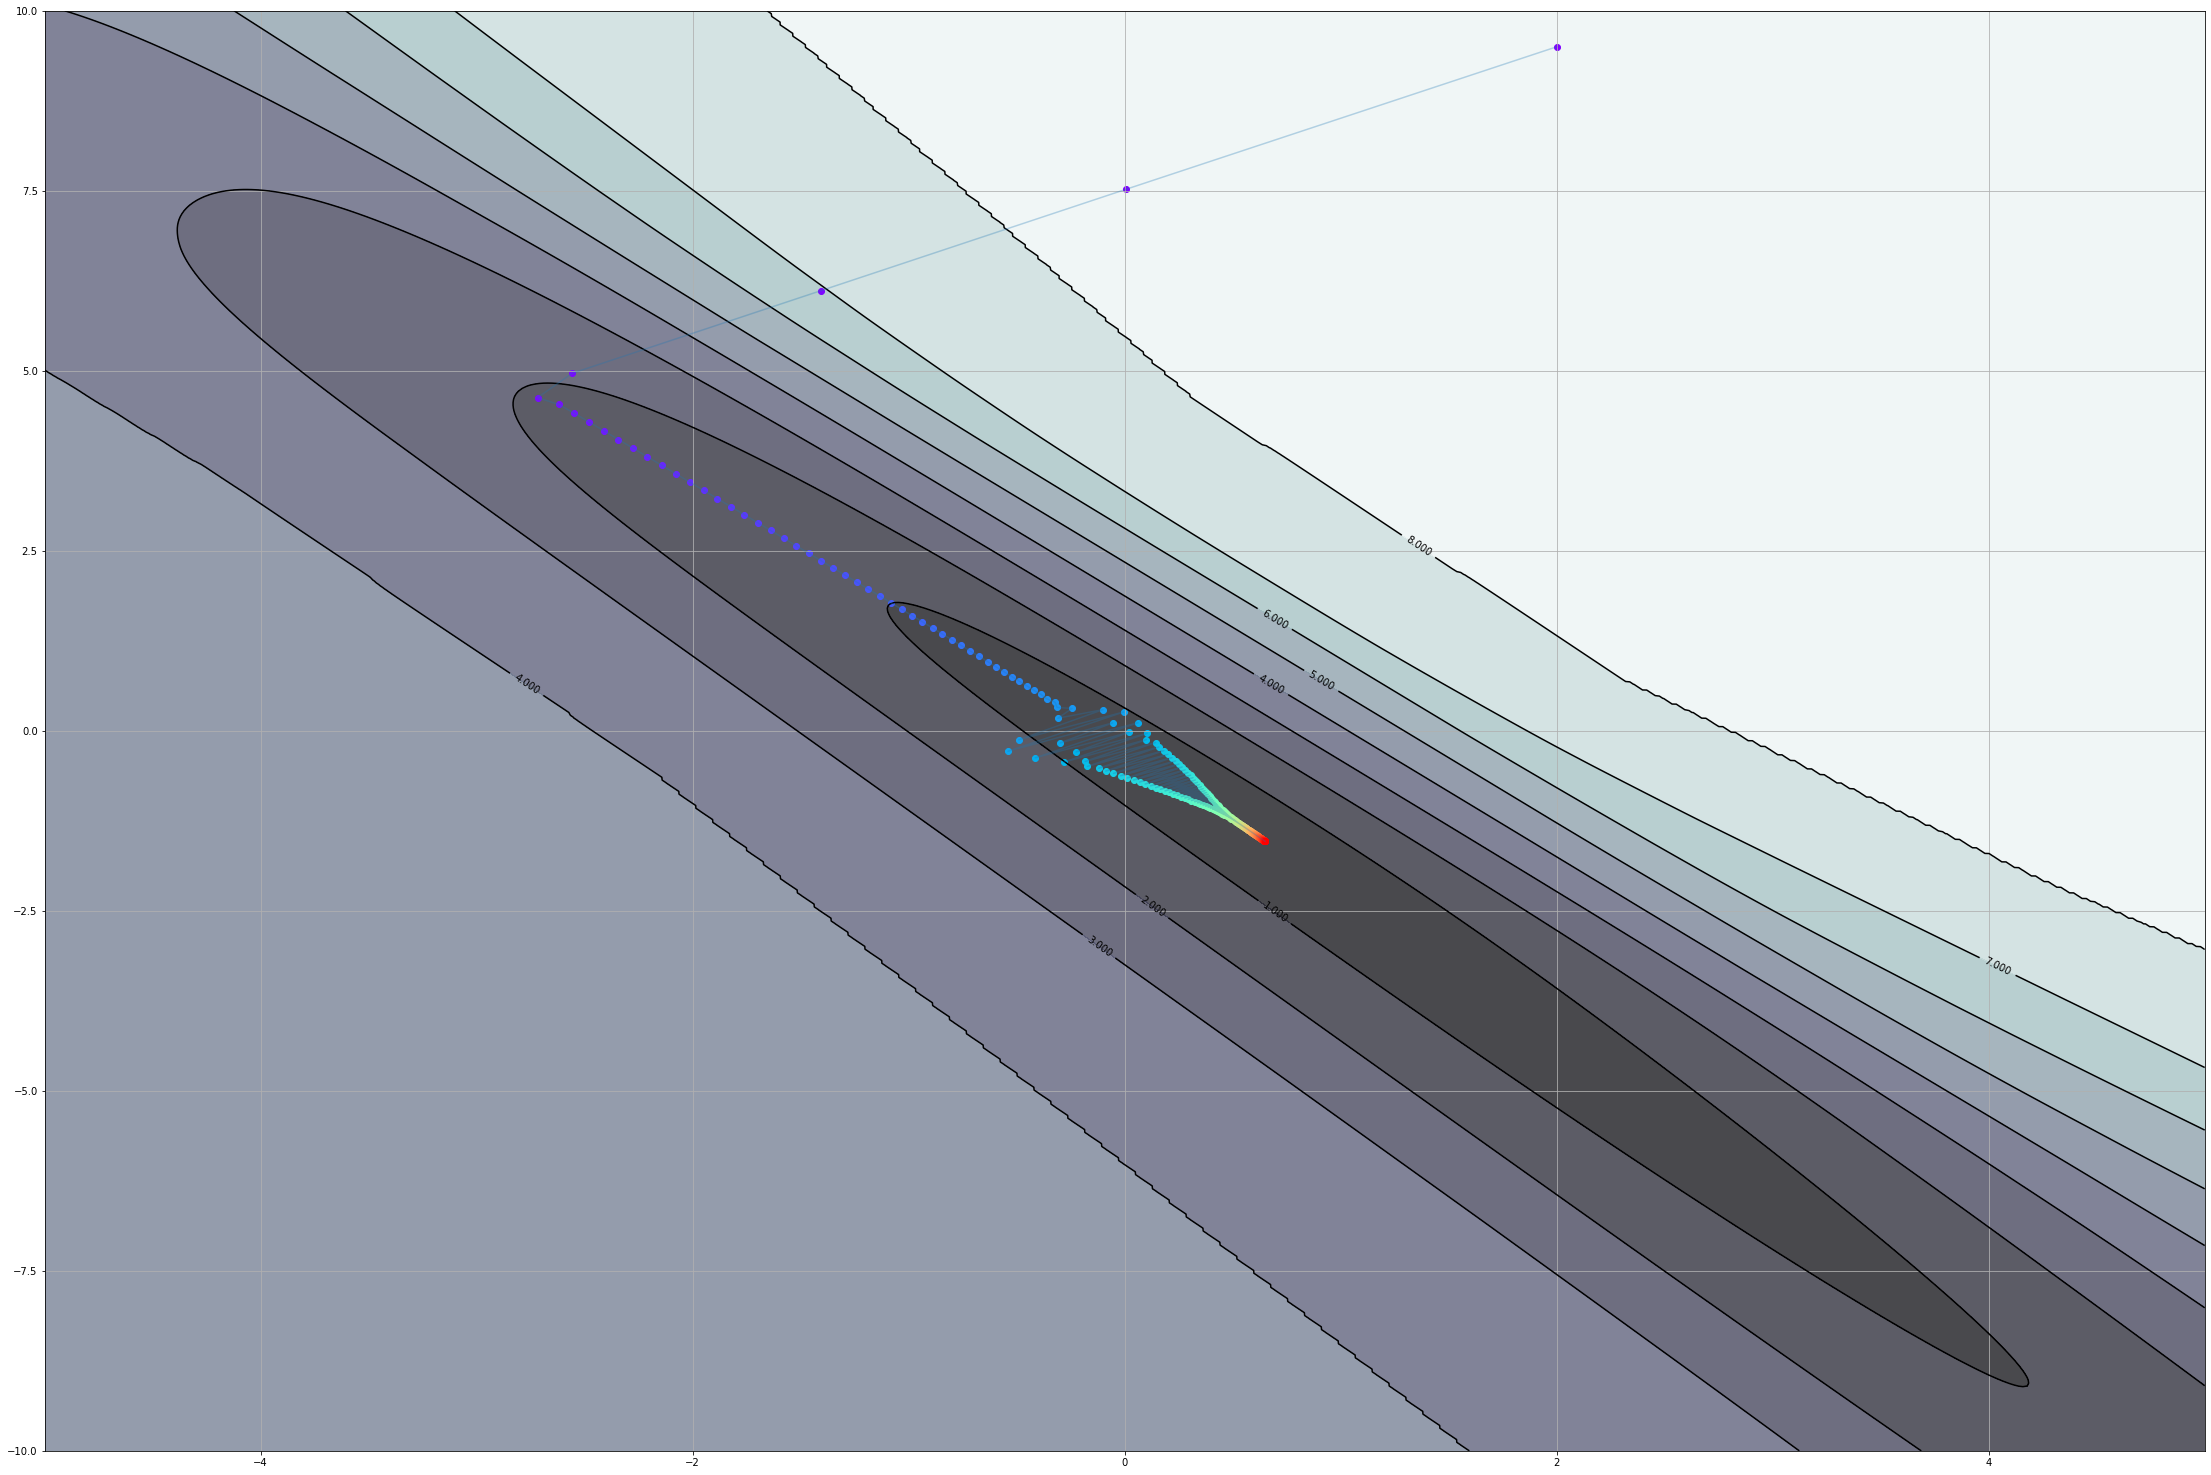

In [ ]:
viz(tf.keras.optimizers.Adagrad(learning_rate=2), 250, [2.0, 9.5])

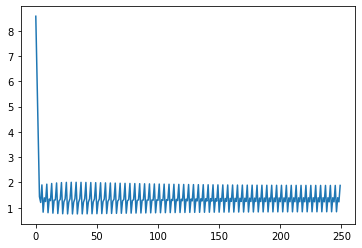

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'


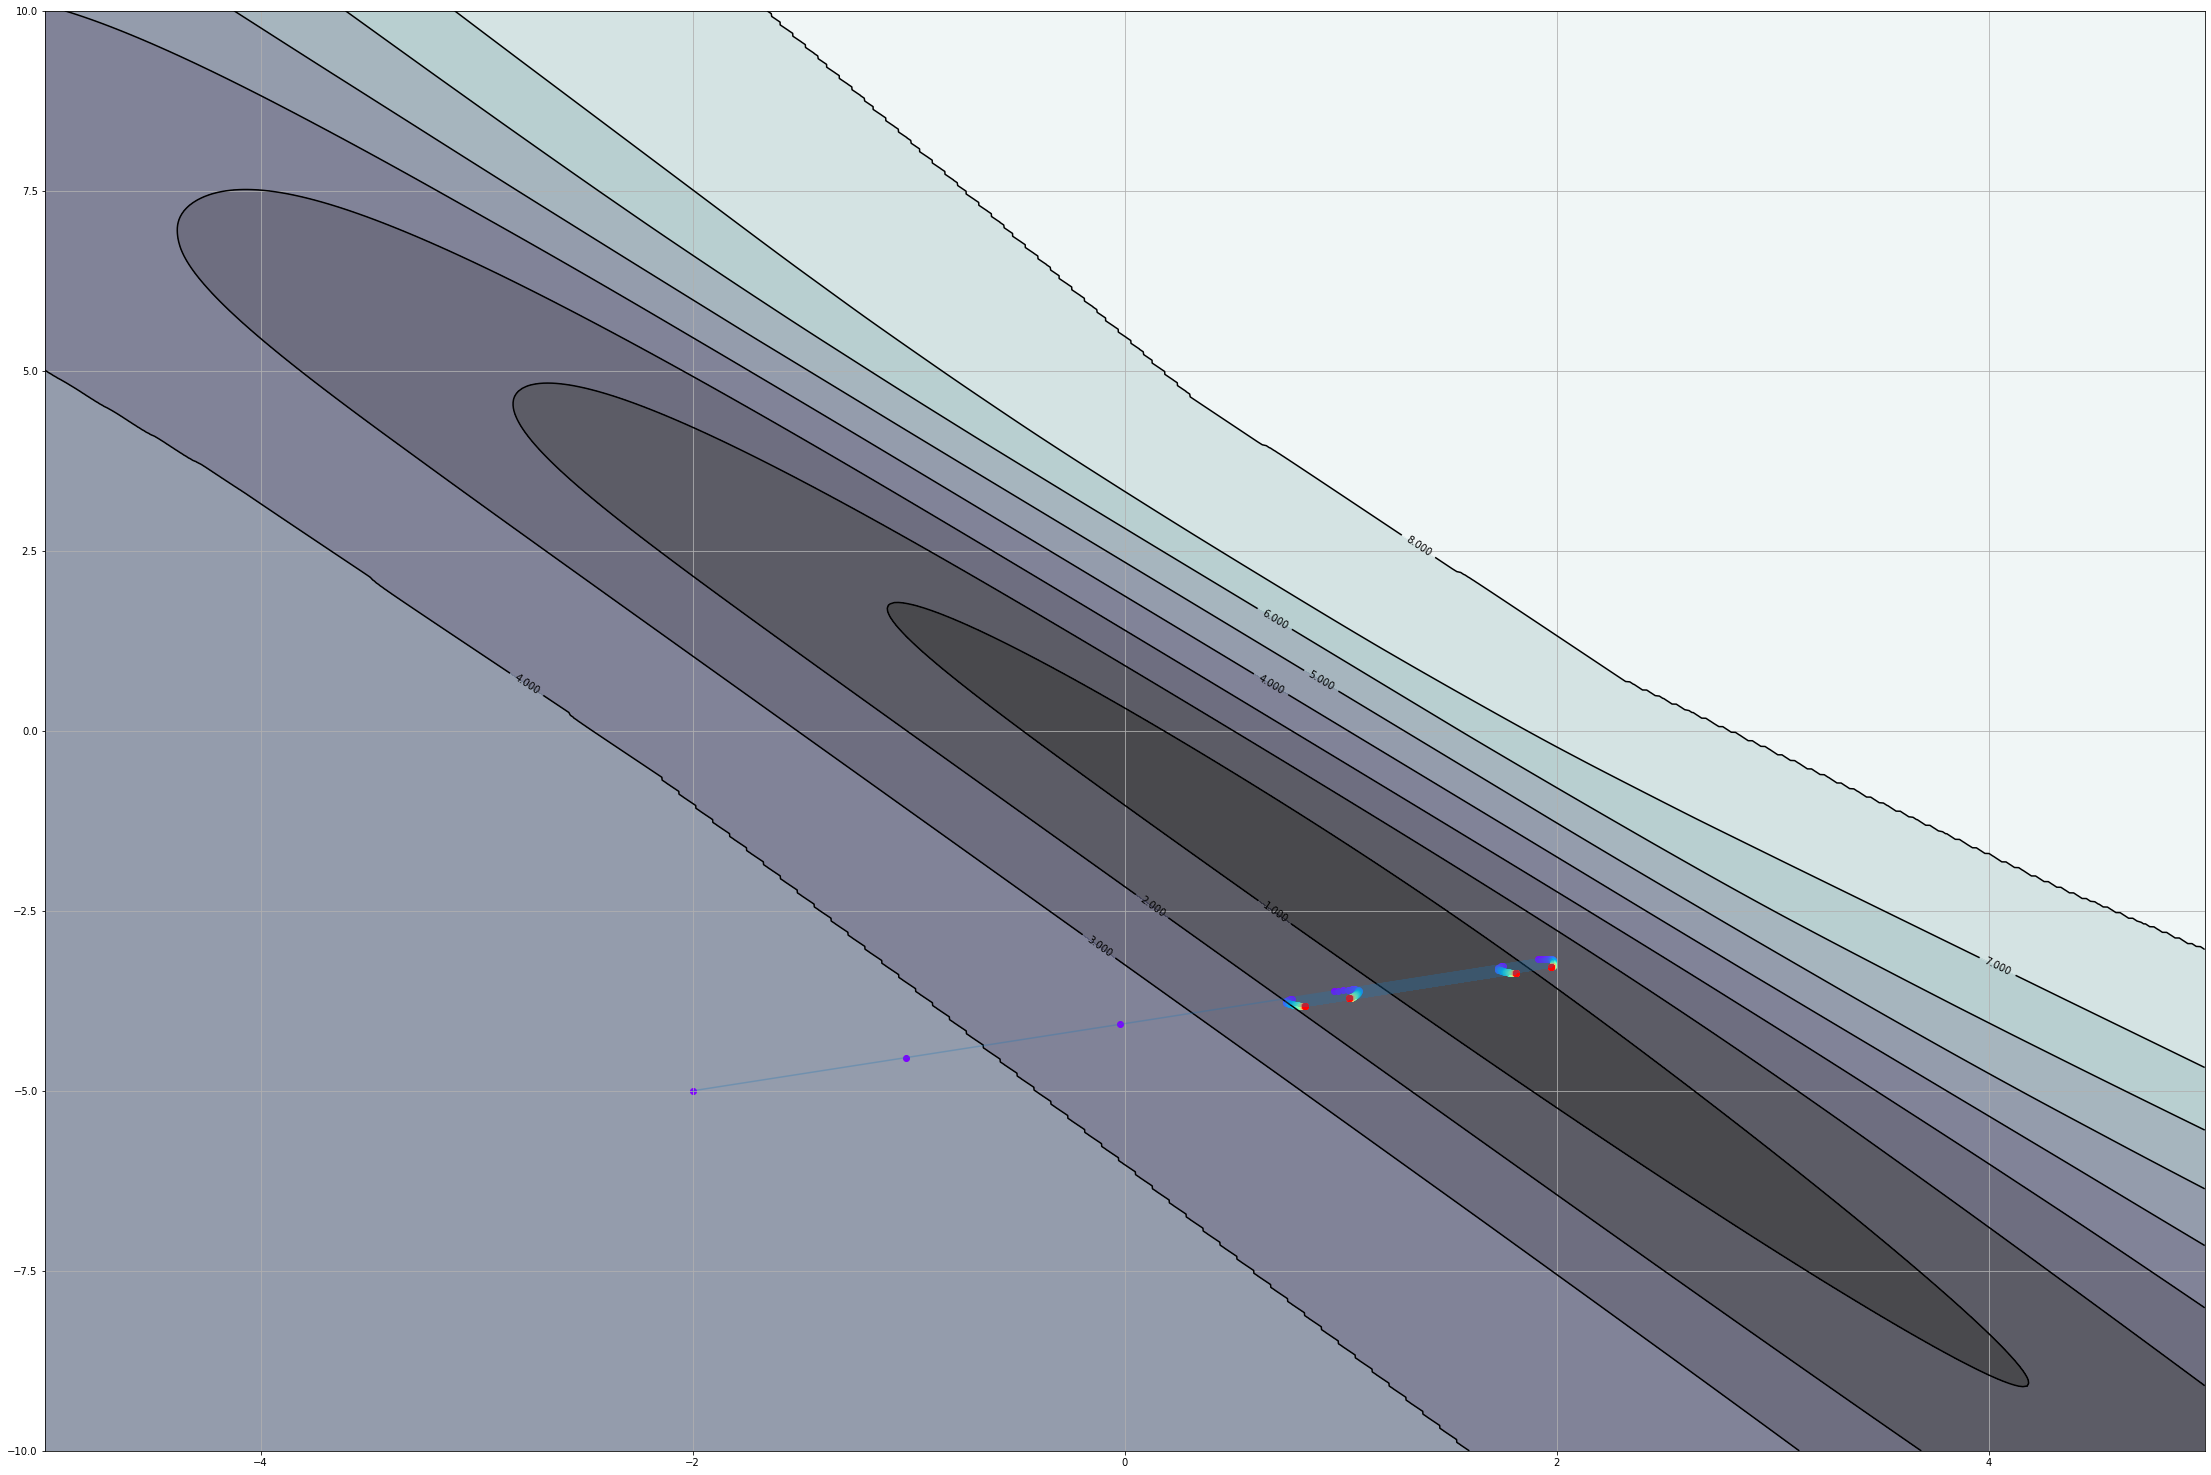

In [ ]:
viz(tf.keras.optimizers.SGD(learning_rate=0.5), 250, [-2.0, -5.0])

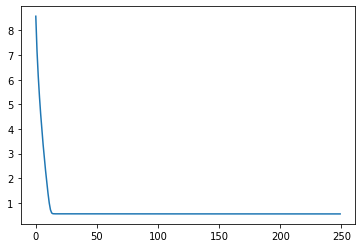

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'


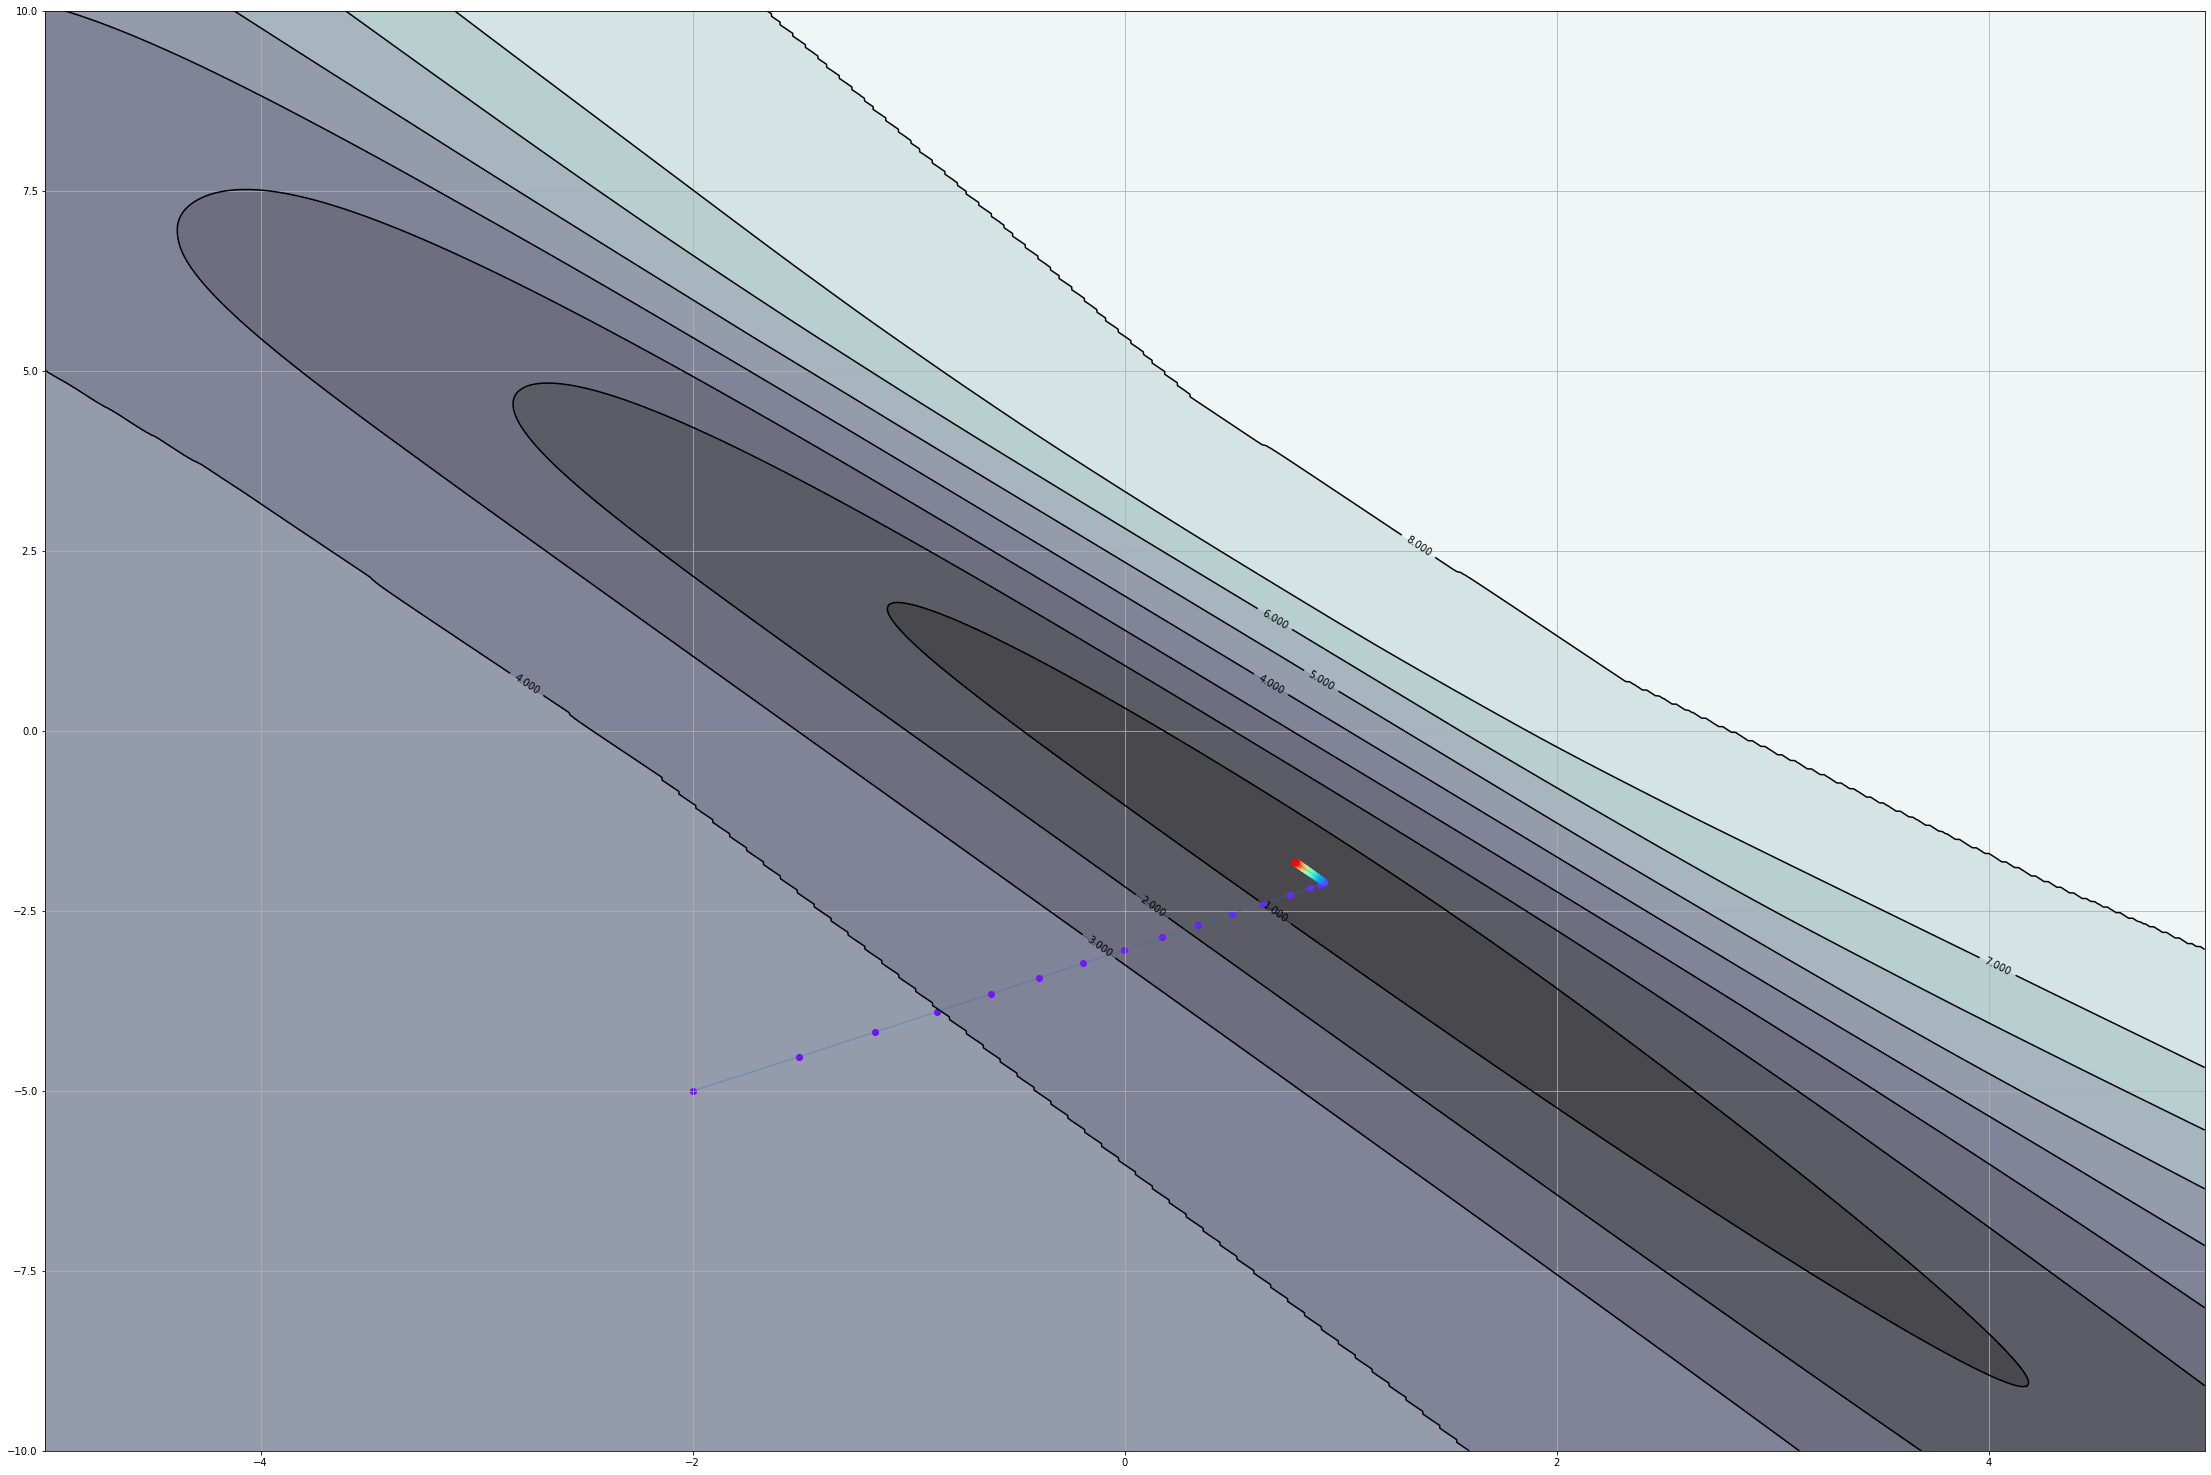

In [ ]:
viz(tf.keras.optimizers.Adagrad(learning_rate=0.5), 250, [-2.0, -5.0])

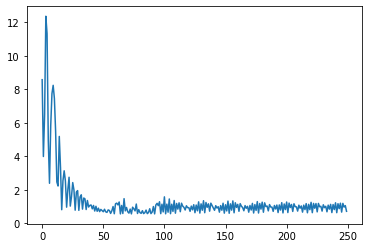

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'


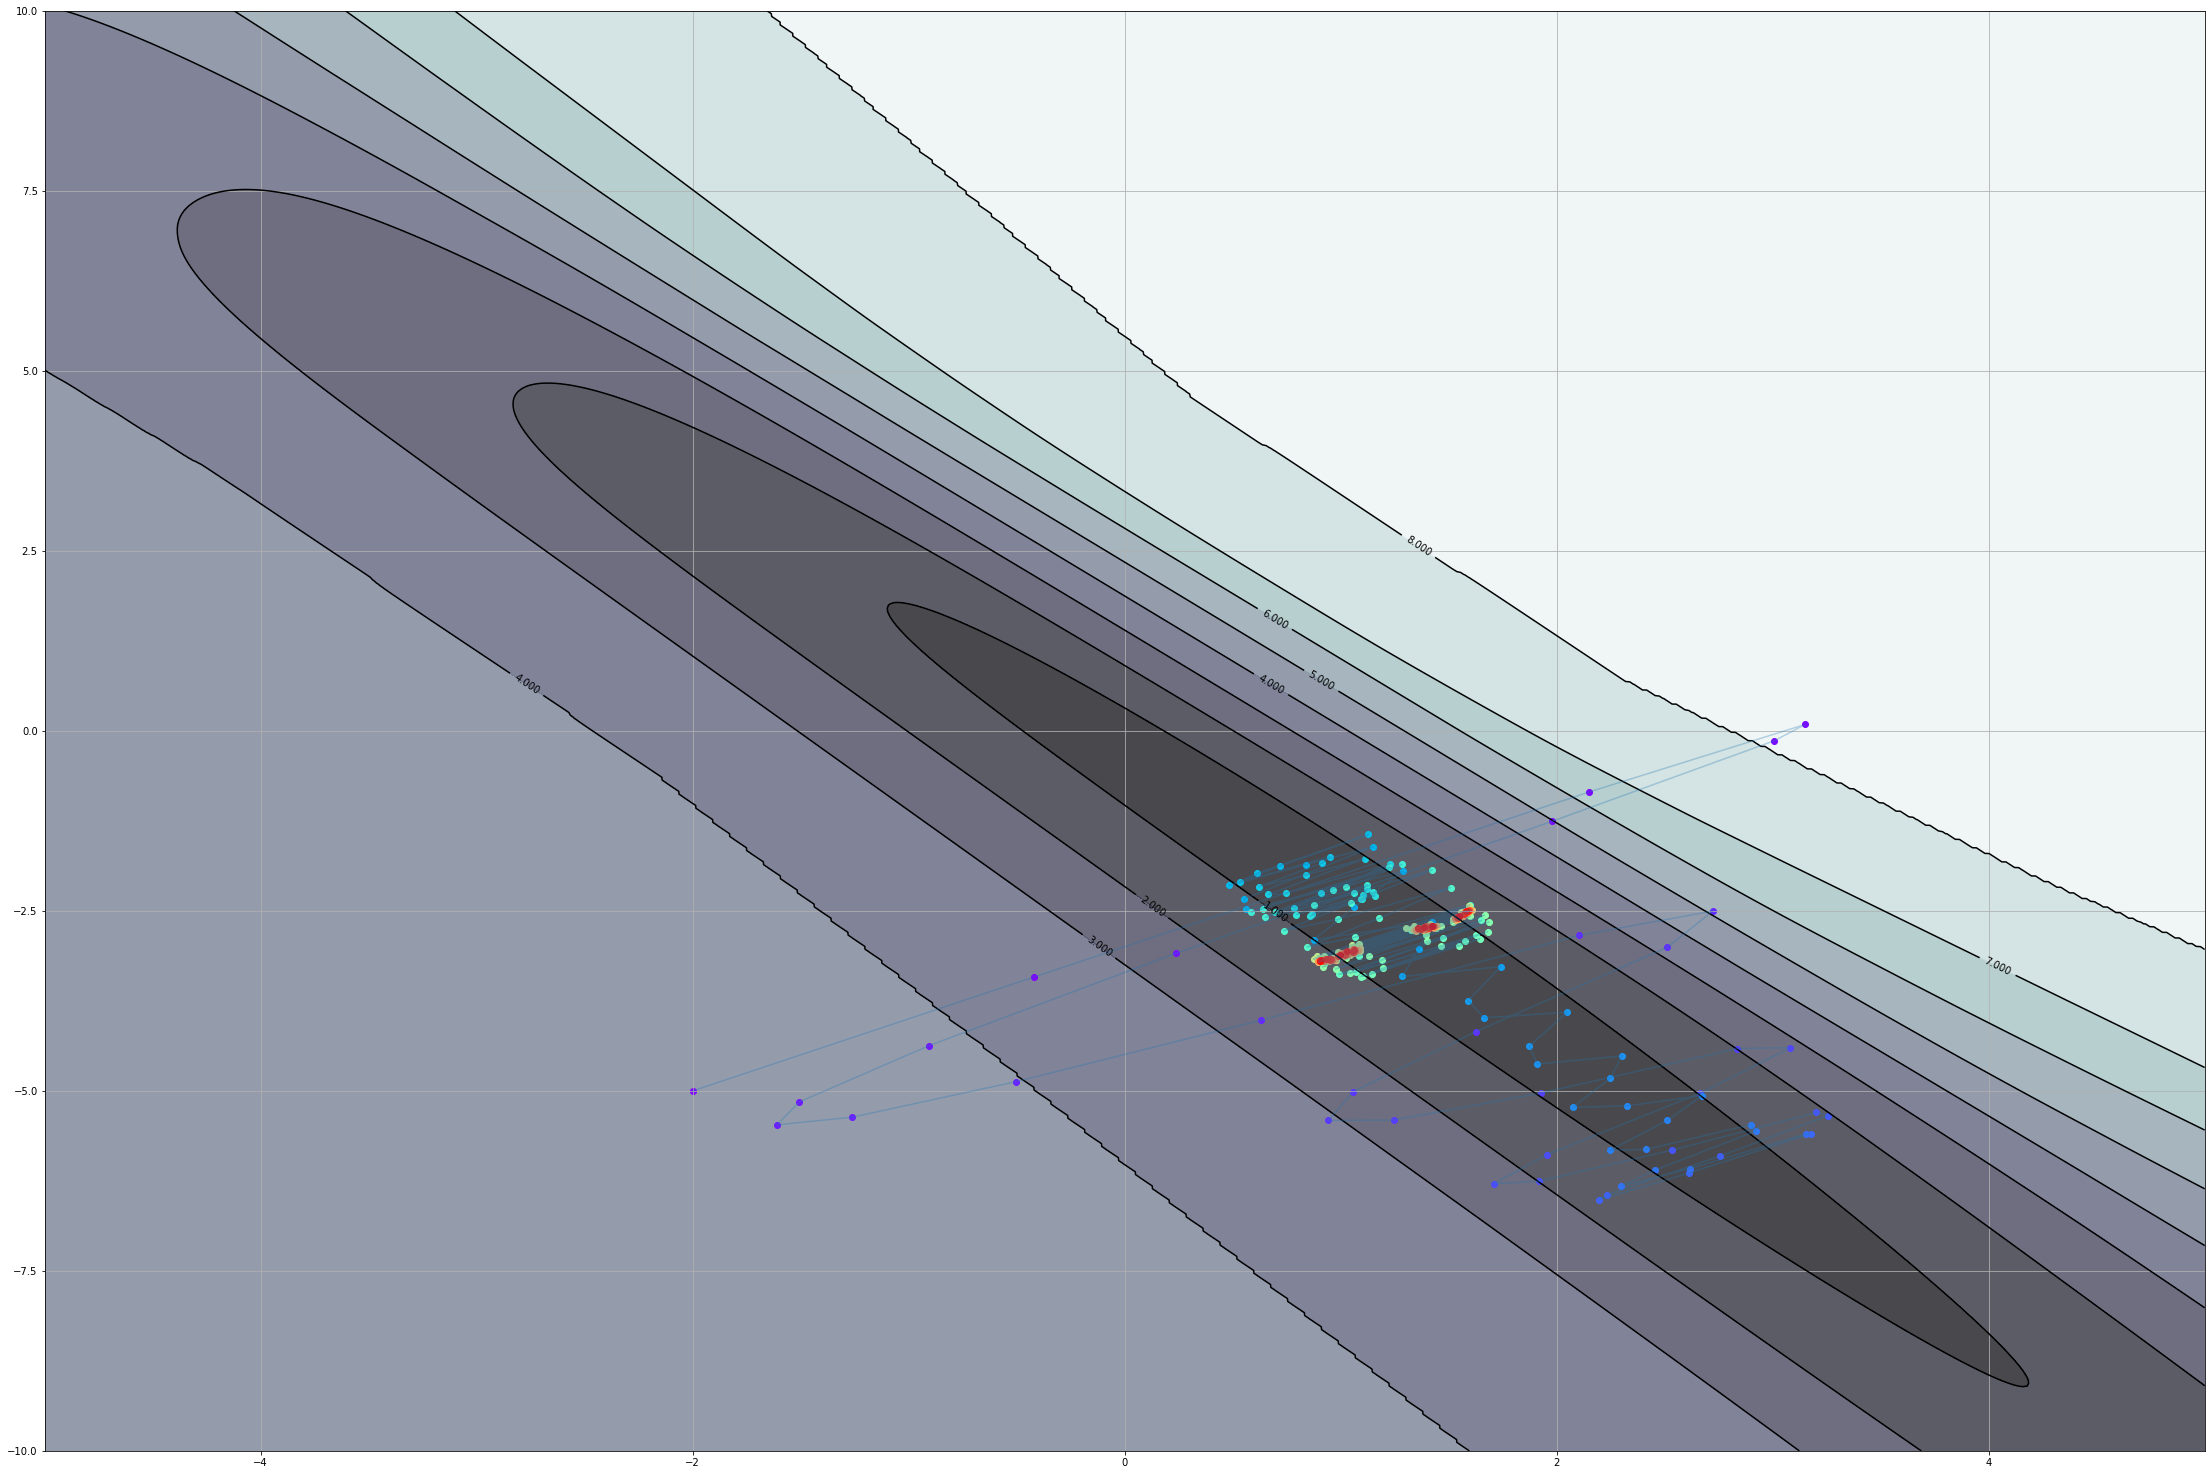

In [ ]:
viz(tf.keras.optimizers.RMSprop(learning_rate=0.5, momentum=0.9), 250, [-2.0, -5.0])

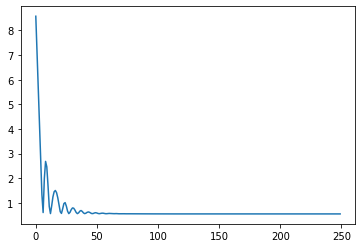

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'


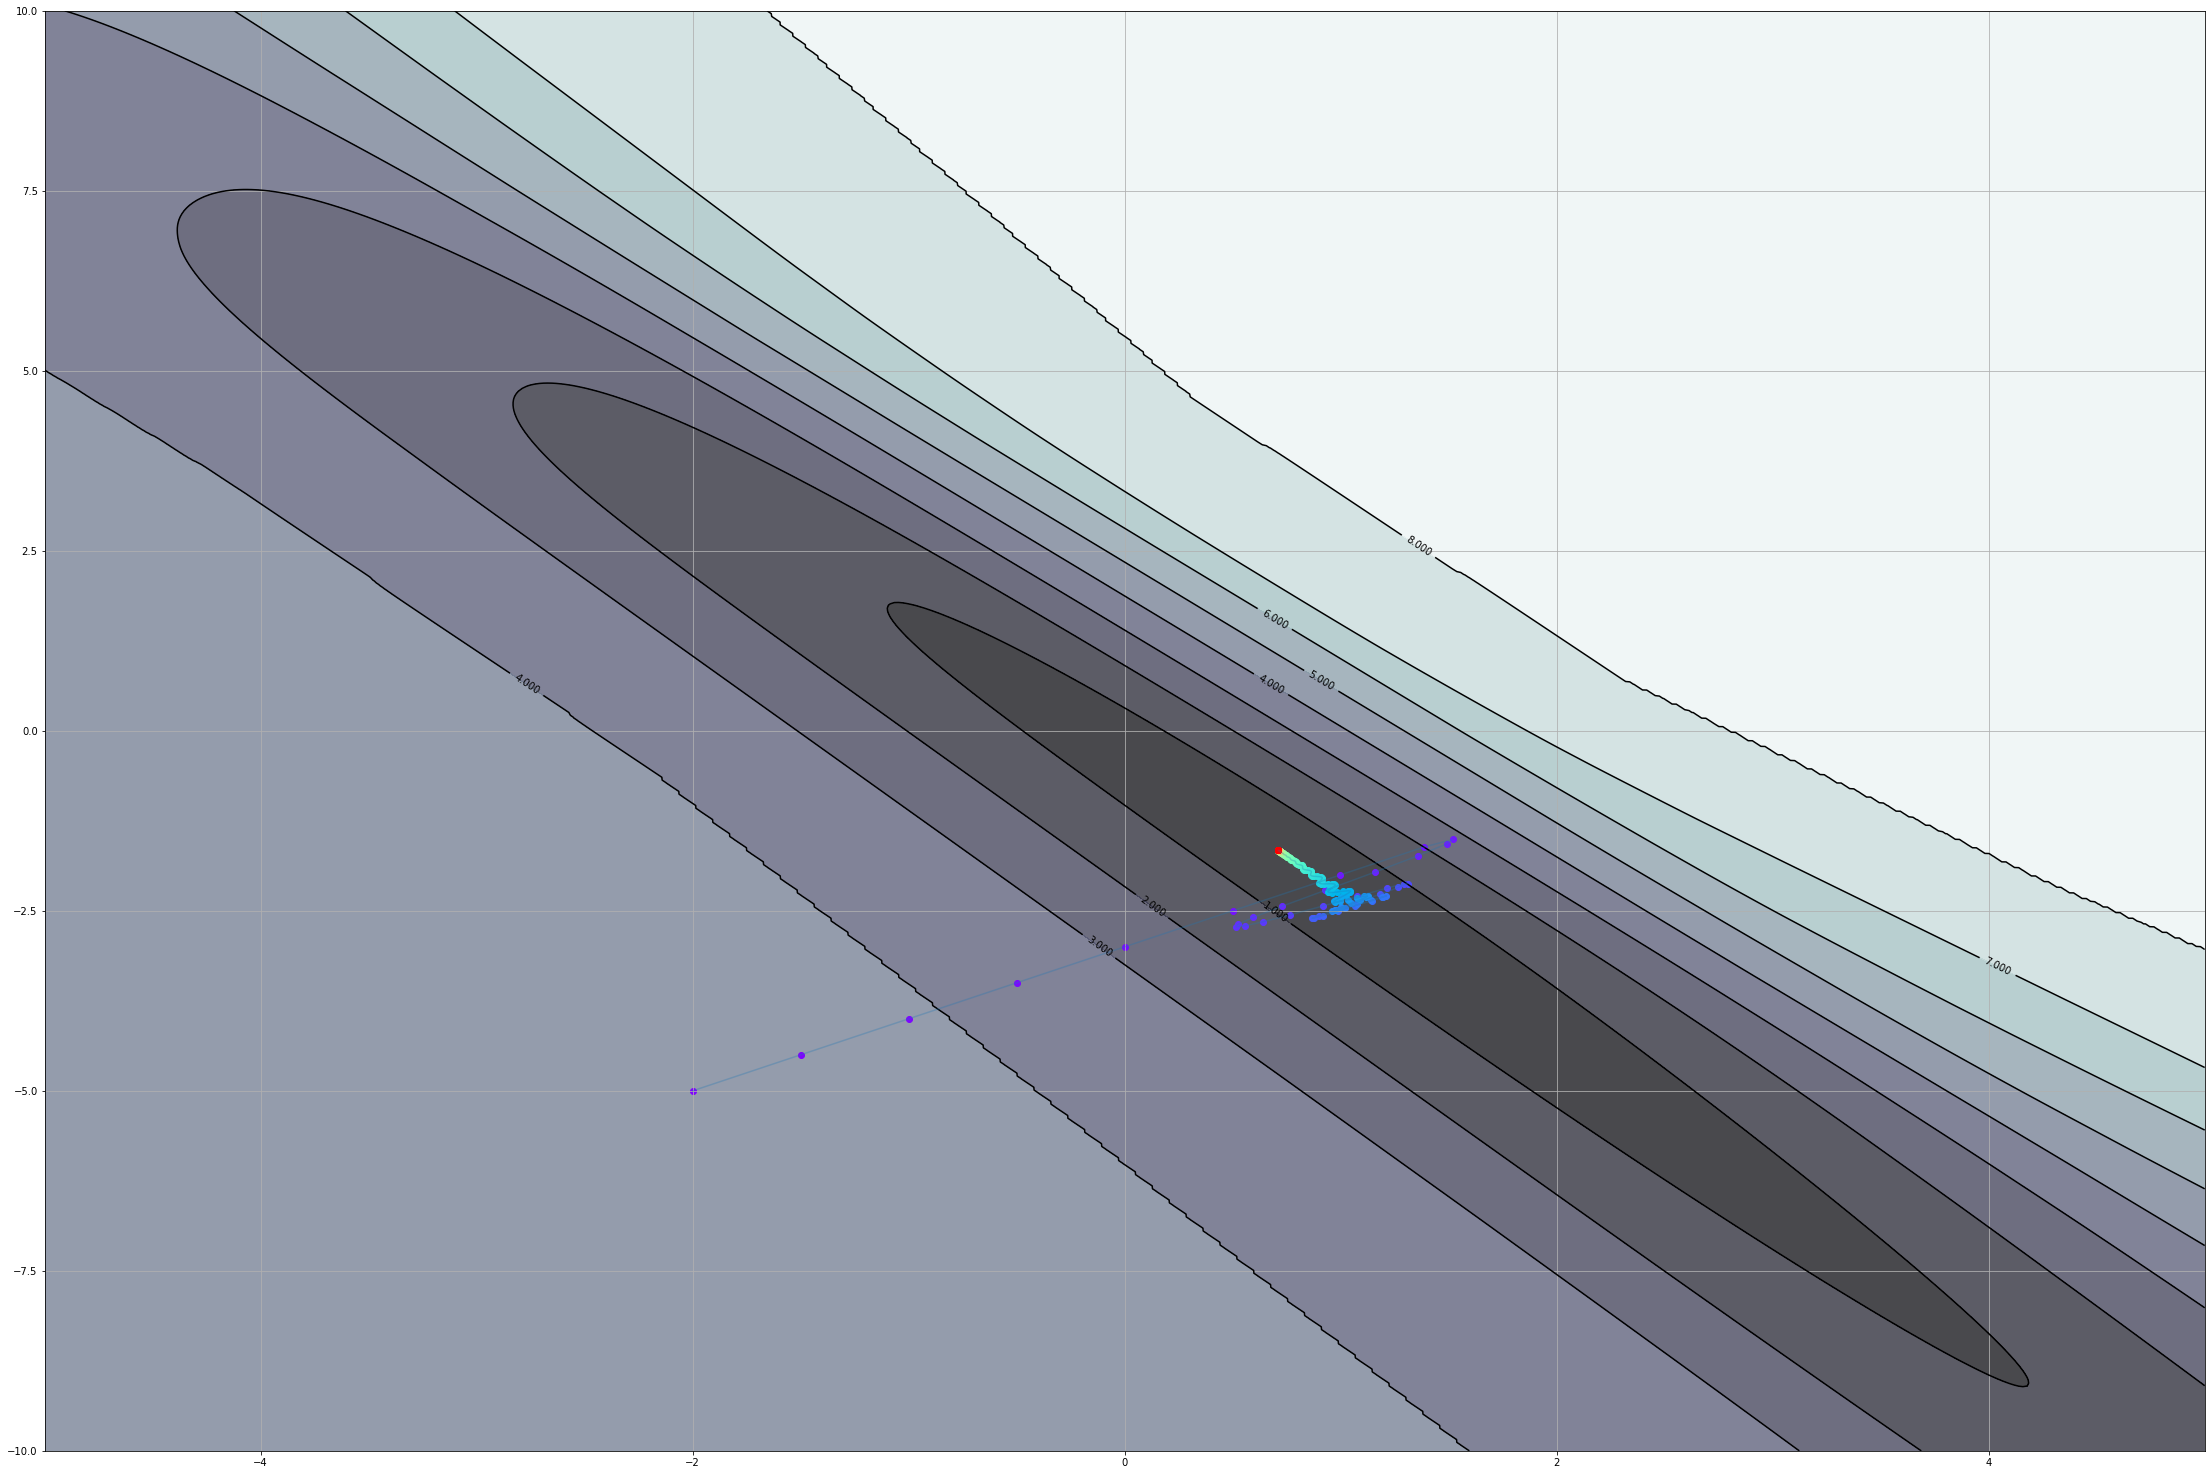

In [ ]:
viz(tf.keras.optimizers.Adam(learning_rate=0.5), 250, [-2.0, -5.0])

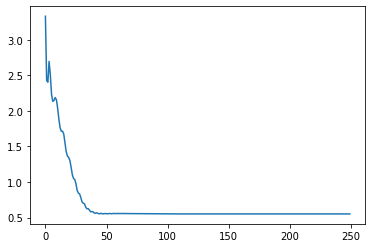

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'


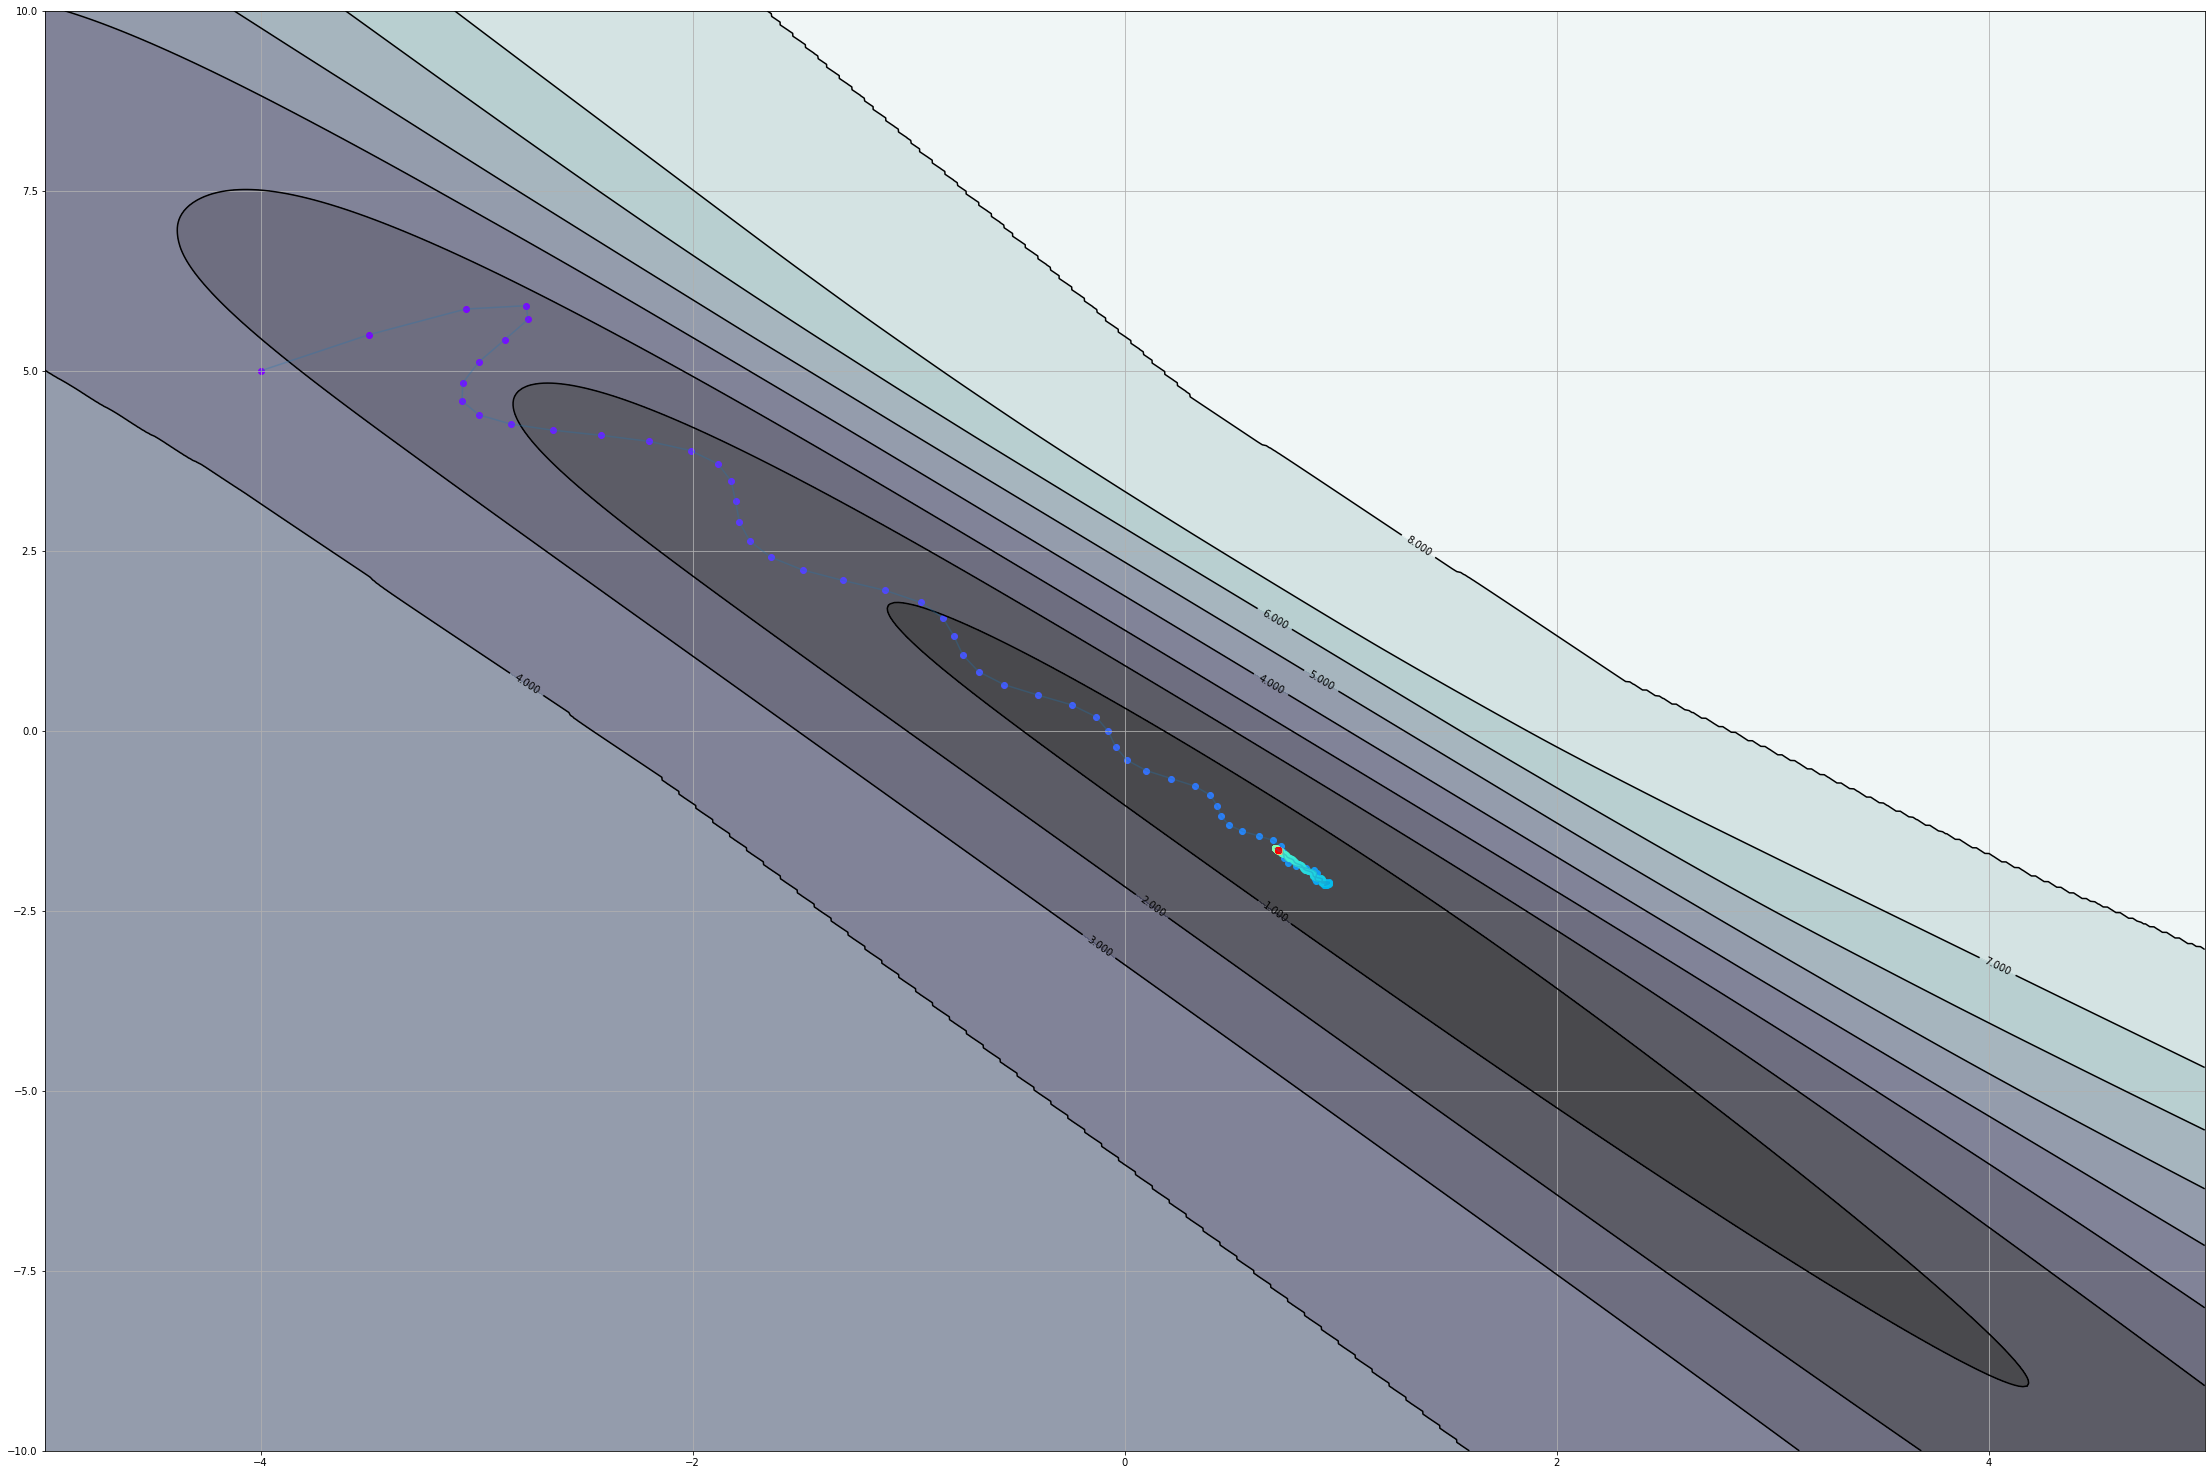

In [ ]:
viz(tf.keras.optimizers.Adam(learning_rate=0.5), 250, [-4.0, 5.0])